# Simple IMPT plan optimization

In [ ]:
import math
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.data.plan import FidObjective
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import saveRTPlan, loadRTPlan
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D, resampleImage3D
from opentps.core.processing.planOptimization.planOptimization import IMPTPlanOptimizer

## CT calibration and BDL

In [ ]:
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

## Create synthetic CT and ROI

In [ ]:
patient = Patient()
patient.name = 'Patient'

ctSize = 150

ct = CTImage()
ct.name = 'CT'
ct.patient = patient


huAir = -1024.
huWater = ctCalibration.convertRSP2HU(1.)
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data

roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[100:120, 100:120, 100:120] = True
roi.imageArray = data

## Configure dose engine

In [ ]:
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.nbPrimaries = 5e4
mc2.ctCalibration = ctCalibration

mc2._independentScoringGrid = True
scoringSpacing = [2, 2, 2]
mc2._scoringVoxelSpacing = scoringSpacing

## Design plan

In [ ]:
beamNames = ["Beam1"]
gantryAngles = [0.]
couchAngles = [0.]

planInit = PlanDesign()
planInit.ct = ct
planInit.targetMask = roi
planInit.gantryAngles = gantryAngles
planInit.beamNames = beamNames
planInit.couchAngles = couchAngles
planInit.calibration = ctCalibration
planInit.spotSpacing = 6.0
planInit.layerSpacing = 6.0
planInit.targetMargin = 0.0
planInit.scoringVoxelSpacing = [2, 2, 2]

plan = planInit.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"

beamlets = mc2.computeBeamlets(ct, plan, roi=[roi])
plan.planDesign.beamlets = beamlets
doseImageRef = beamlets.toDoseImage()

## Objectives

In [ ]:
plan.planDesign.objectives = ObjectivesList()
plan.planDesign.objectives.setTarget(roi.name, 20.0)

plan.planDesign.objectives.fidObjList = []
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.5, 1.0)

## Optimize plan

In [ ]:
solver = IMPTPlanOptimizer(method='Scipy-LBFGS', plan=plan, maxit=50)
w, doseImage, ps = solver.optimize()

plan.spotMUs = np.square(w).astype(np.float32)

## Final dose computation

In [ ]:
mc2.nbPrimaries = 1e7
doseImage = mc2.computeDose(ct, plan)

## Plots

D95 = 17.46826171875 Gy
D5 = 24.15771484375 Gy
D5 - D95 =  6.689453125 Gy


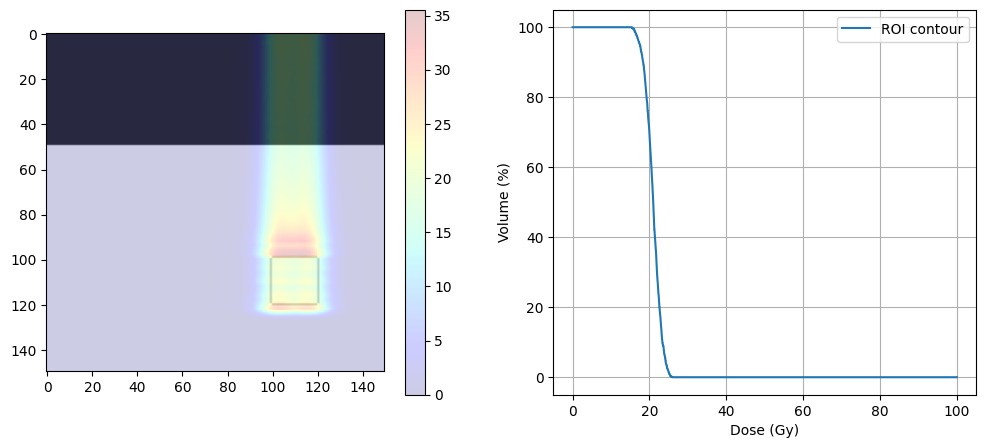

In [15]:
 # Compute DVH on resampled contour
roiResampled = resampleImage3D(roi, origin=ct.origin, gridSize=scoringGridSize, spacing=scoringSpacing)
target_DVH = DVH(roiResampled, doseImage)
print('D95 = ' + str(target_DVH.D95) + ' Gy')
print('D5 = ' + str(target_DVH.D5) + ' Gy')
print('D5 - D95 =  {} Gy'.format(target_DVH.D5 - target_DVH.D95))

# center of mass
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)

# Display dose
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#ax[0].axes.get_xaxis().set_visible(False)
#ax[0].axes.get_yaxis().set_visible(False)
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
plt.grid(True)
plt.legend()

plt.show()